# Electricity estimations

This builds from the 2016-02-17-daily-predicted-use notebook.

I'd like to understand the contributions to the total energy use from the different end uses.

TODO:

- filter outliers or bad hours per week numbers ()
- why are all counts 1184, shouldn't there be nulls?
- are we averaging in zeros that should be nulls?
- why isn't the survey preventing hours and per week responses if you don't have the appliance?
- do the energy averages omit the null values?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pysentani as sti
survey = pd.read_excel('../data-survey/sentani-merged-cleaned-2015-06-10.xlsx')
survey['access_type'] = sti.access_type(survey)

/Users/dsoto/anaconda/envs/sotolab/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Filtering bad responses

There are some responses currently in the survey that report use above 24 hours per day or more than 7 days per week.  For now if these exceed the maximum, I'm replacing with the maximum.  We may want to clean the data set and repost a new version.

When we filter the data, we have to account for the presence of null values.

In [2]:
for app in ['TV', 'radio', 'fridge', 'fan', 'rice_cooker', 'lighting']:
    # generate column labels for each appliance
    wk_col = 'app_{}_per_wk'.format(app)
    hr_col = 'app_{}_hrs'.format(app)
    # if null or within range use value, otherwise use max possible value
    survey[hr_col] = survey[hr_col].where(survey[hr_col].isnull() | (survey[hr_col] <= 24), 24)
    survey[wk_col] = survey[wk_col].where(survey[wk_col].isnull() | (survey[wk_col] <= 7), 7)

    # ensure non-null values are within bounds
    assert(all(survey[wk_col].dropna() <= 7))
    assert(all(survey[wk_col].dropna() >= 0))
    assert(all(survey[hr_col].dropna() <= 24))
    assert(all(survey[hr_col].dropna() >= 0))

We use these hourly ranges to estimate the electricity use for each appliance type.

$$ \textrm{daily energy (kWh)} = \left(\frac{use\ times\ per\ week * hours\ per\ use}{7}\right)power(kW)$$

In [3]:
powers = {'TV':0.040, 
          'fridge':0.100, 
          'radio':0.010, 
          'fan':0.050, 
          'rice_cooker':0.350, 
          'lighting':0.050}
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']

for appliance in appliance_list:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(appliance)
    hr_col = 'app_{}_hrs'.format(appliance)
    energy_col = 'daily_{}_energy'.format(appliance)
    weekly_hr_col = 'weekly_{}_hrs'.format(appliance)
    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]    
    survey[energy_col] = survey[weekly_hr_col] / 7 * powers[appliance]

At this point, we have a data frame containing the energy use of each household.  If we sum these we should get the overall village use of that appliance energy type.

Since the averages do not include nulls and we assume our survey sample is reflective of the overall population, these will be an estimate of the per capita use for households owning that appliance.

To get the overall per capita averages, I fill nulls with zeros and then group by access type.

In [4]:
columns = ['access_type', 
           'daily_TV_energy', 
           'daily_fridge_energy', 
           'daily_radio_energy', 
           'daily_fan_energy', 
           'daily_rice_cooker_energy', 
           'daily_lighting_energy']
energy_data = survey[columns].copy(deep=True)
energy_data.head()

,access_type,daily_TV_energy,daily_fridge_energy,daily_radio_energy,daily_fan_energy,daily_rice_cooker_energy,daily_lighting_energy
0,no_access,0.160000,NaN,0.020000,NaN,NaN,NaN
1,no_access,0.080000,NaN,0.008571,NaN,NaN,0.042857
2,no_access,0.120000,NaN,NaN,NaN,NaN,NaN
3,no_access,0.022857,NaN,NaN,NaN,NaN,0.114286
4,no_access,NaN,NaN,NaN,NaN,NaN,0.300000


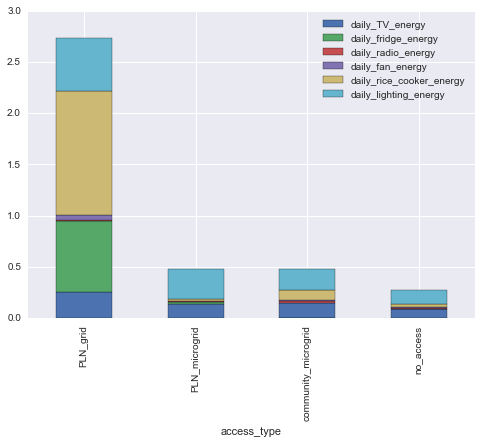

In [5]:
# this should be averall per capita consumption by filling nulls with zeros
energy_data.fillna(0).groupby('access_type').mean().plot(kind='bar', stacked=True)
plt.show()

In [6]:
# am I having the index label problem here?
aggregated_energy_data = energy_data.fillna(0).groupby('access_type').mean()
aggregated_energy_data['access_type'] = aggregated_energy_data.index
aggregated_energy_data

,daily_TV_energy,daily_fridge_energy,daily_radio_energy,daily_fan_energy,daily_rice_cooker_energy,daily_lighting_energy,access_type
access_type,,,,,,,
PLN_grid,0.249333,0.696700,0.008495,0.053808,1.207835,0.522756,PLN_grid
PLN_microgrid,0.134622,0.020000,0.007790,0.006050,0.016471,0.294412,PLN_microgrid
community_microgrid,0.148995,0.000000,0.013915,0.008598,0.100000,0.205291,community_microgrid
no_access,0.083167,0.003812,0.013377,0.009992,0.020821,0.137055,no_access


/Users/dsoto/anaconda/envs/sotolab/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


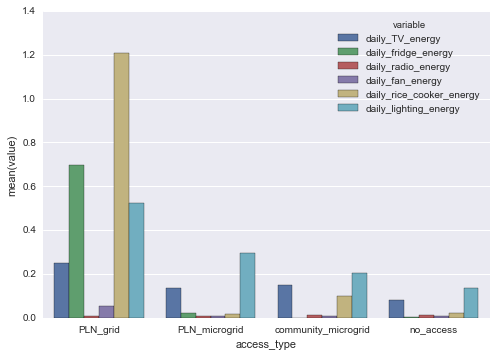

In [8]:
energy_columns = ['daily_TV_energy', 
           'daily_fridge_energy', 
           'daily_radio_energy', 
           'daily_fan_energy', 
           'daily_rice_cooker_energy', 
           'daily_lighting_energy']
tidy_energy_data = pd.melt(aggregated_energy_data, 
                           id_vars='access_type', 
                           value_vars=energy_columns)
sns.barplot(data=tidy_energy_data, x='access_type', hue='variable', y='value')
plt.savefig('energy-by-end-use.png')